In [1]:
import json
from prettytable import PrettyTable
import json
import os
import random
import pandas as pd

# Read the jsonl file and convert it to a JSON list
def jsonl_to_json_list(jsonl_file_path):
    json_list = []
    with open(jsonl_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_obj = json.loads(line.strip())  # Parse each line as JSON
            json_list.append(json_obj)
    
    return json_list

# Save the JSON list to a file
def save_as_json(json_list, output_file_path):
    with open(output_file_path, 'w', encoding='utf-8') as outfile:
        json.dump(json_list, outfile, indent=4)

def save_as_jsonl(json_list, output_file_path):
    with open(output_file_path, 'w', encoding='utf-8') as outfile:
        for json_obj in json_list:
            json.dump(json_obj, outfile)
            outfile.write('\n')

| Model | Task | Subtask | Method | Accuracy | Cost per sample(USD) | Time per sample(s) | Total Number |
|-------|------|---------|---------|----------|---------------------|-------------------|--------------|
| gpt-4o-mini | medqa | test_hard | avg | 30.0% | 0.0022898444999999933 | 60.3021 | 100 |
| gpt-4o | medqa | test_hard | avg | 48.0% | 0.06224990000000007 | 61.4523 | 100 |
| DeepSeek-V3 | medqa | test_hard | avg | 28.0% | 0.012194999999999978 | 235.1550 | 100 |
| gpt-4o-mini | pubmedqa | test_hard | avg | 15.0% | 0.0018243375000000206 | 64.7343 | 100 |
| gpt-4o | pubmedqa | test_hard | avg | 18.0% | 0.051182649999999726 | 71.1453 | 100 |
| DeepSeek-V3 | pubmedqa | test_hard | avg | 18.0% | 0.009928999999999986 | 238.4034 | 100 |
| gpt-4o-mini | medmcqa | test_hard | avg | 25.0% | 0.0013675875000000045 | 49.3986 | 100 |
| gpt-4o | medmcqa | test_hard | avg | 31.0% | 0.040385800000000034 | 42.9243 | 100 |
| DeepSeek-V3 | medmcqa | test_hard | avg | 22.0% | 0.00647498000000001 | 1

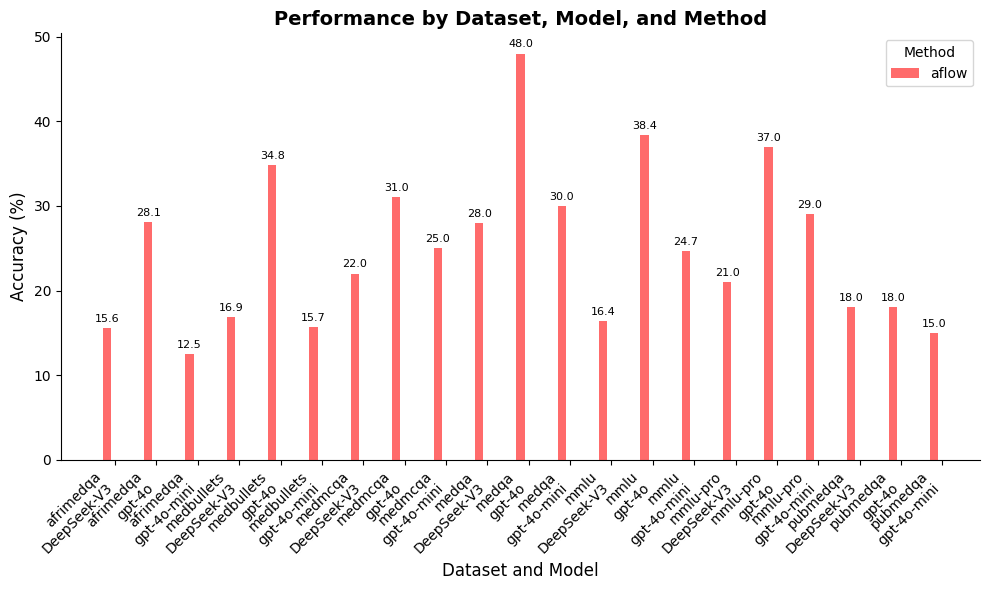

In [ ]:
def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = [json.loads(line.strip()) for line in file]
    return data

def deduplicate_data(data):
    seen = set()
    deduplicated_data = []
    for item in data:
        idx = item['realidx']
        if idx not in seen:
            deduplicated_data.append(item)
            seen.add(idx)
    return deduplicated_data

def calculate_accuracy(data):
    correct_predictions = 0
    total_predictions = len(data)
    for item in data:
        if 'predicted_answer' not in item:
            print(item['realidx'])
        if item['answer_idx'] == item['predicted_answer']:
            correct_predictions += 1
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy

def calculate_cost_from_token_usage(data, model):
    total_cost = 0
    for item in data:
        if 'cost' in item:
            total_cost += item['cost']
        elif model == 'gpt-4o-mini':
            total_cost += item['token_usage']['prompt_tokens'] * 0.15 / 1000000 + item['token_usage']['completion_tokens'] * 0.6 / 1000000
        elif model == 'gpt-4o':
            total_cost += item['token_usage']['prompt_tokens'] * 2.5 / 1000000 + item['token_usage']['completion_tokens'] * 10 / 1000000
        elif model == 'o3-mini' or model == 'o1-mini':
            total_cost += item['token_usage']['prompt_tokens'] * 1.1 / 1000000 + item['token_usage']['completion_tokens'] * 4.4 / 1000000
        elif model == 'claude-3-5-sonnet':
            total_cost += item['token_usage']['prompt_tokens'] * 3.0 / 1000000 + item['token_usage']['completion_tokens'] * 15.0 / 1000000
        elif model == 'claude-3-5-haiku':
            total_cost += item['token_usage']['prompt_tokens'] * 0.8 / 1000000 + item['token_usage']['completion_tokens'] * 4.0 / 1000000
        elif model == 'QwQ-32B-Preview':
            total_cost += item['token_usage']['prompt_tokens'] * 1.2 / 1000000 + item['token_usage']['completion_tokens'] * 1.2 / 1000000
        elif model == 'DeepSeek-R1':
            total_cost += item['token_usage']['prompt_tokens'] * 7 / 1000000 + item['token_usage']['completion_tokens'] * 7 / 1000000
        elif model == 'DeepSeek-V3':
            total_cost += item['token_usage']['prompt_tokens'] * 1.25 / 1000000 + item['token_usage']['completion_tokens'] * 1.25 / 1000000
        elif model == 'Llama-3.3-70B-Instruct-Turbo':
            total_cost += item['token_usage']['prompt_tokens'] * 0.88 / 1000000 + item['token_usage']['completion_tokens'] * 0.88 / 1000000
    return total_cost / len(data)

def calculate_time_from_data(data):
    total_time = 0
    for item in data:
        total_time += item['time_elapsed']
    return total_time / len(data)

tasks = {
    'medqa': ['test_hard'],
    'pubmedqa': ['test_hard'],
    'medmcqa': ['test_hard'],
    'medbullets': ['test_hard'],
    'mmlu': ['test_hard'],
    'mmlu-pro': ['test_hard'],
    'afrimedqa': ['test_hard'],
    'medexqa': ['test'],
    'medxpertqa-r': ['test'],
    'medxpertqa-u': ['test'],
}
models = [
    'gpt-4o-mini',
    'gpt-4o',
    'DeepSeek-V3',
    'o1-mini',
    'o3-mini',
    'QwQ-32B-Preview',
    'DeepSeek-R1',
    'Llama-3.3-70B-Instruct-Turbo',
    'claude-3-5-sonnet',
    'claude-3-5-haiku'
]
methods = ['zero_shot', 'few_shot', 'cot', 'cot_sc-5', 'multipersona-2', 'self_refine-3', 'medprompt-3', 'medagents', 'mdagents', 'spo', 'aflow']
# methods = ['aflow']

# Create markdown table header
print("| Model | Task | Subtask | Method | Accuracy | Cost per sample(USD) | Time per sample(s) | Total Number |")
print("|-------|------|---------|---------|----------|---------------------|-------------------|--------------|")

total_cost = 0
table = PrettyTable()
table.field_names = ["Model", "Task", "Subtask", "Method", "Accuracy", "Cost per sample(USD)", "Time per sample(s)", "Total Number"]

for task in tasks:
    for subtask in tasks[task]:
        for model in models:
            time_total = 0
            for method in methods:
                try:
                    file_path = f'../../output/{task}/{model}-{task}-{subtask}-{method}.json'
                    data = load_json(file_path)
                    deduplicated_data = deduplicate_data(data)
                    accuracy = calculate_accuracy(deduplicated_data)
                    total = len(deduplicated_data)
                    cost_per_sample = calculate_cost_from_token_usage(deduplicated_data, model)
                    time_total += calculate_time_from_data(deduplicated_data)
                    total_cost += cost_per_sample * total
                    print(f"| {model} | {task} | {subtask} | {method} | {accuracy * 100:.1f}% | {cost_per_sample} | {calculate_time_from_data(deduplicated_data)} | {total} |")
                    table.add_row([
                        model, task, subtask, method,
                        f"{accuracy * 100:.1f}%",
                        cost_per_sample,
                        calculate_time_from_data(deduplicated_data),
                        total
                    ])
                except Exception as e:
                    # print(f"Error loading file {file_path}: {e}")
                    pass
            time_total /= len(methods)
            # print(f"| {model} | {task} | {subtask} | avg | {accuracy * 100:.1f}% | {cost_per_sample} | {time_total:.4f} | {total} |")

print(f"\nTotal cost of experiment: ${total_cost:.2f}")

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Aggregate performance data grouped by dataset (Task) and Model.
# The table rows have the following fields:
# ["Model", "Task", "Subtask", "Method", "Accuracy", "Cost per sample(USD)", "Time per sample(s)", "Total Number"]
aggregated_results = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: {'weighted_sum': 0.0, 'total_samples': 0})))

for row in table._rows:
    model = row[0]
    task = row[1]  # treat 'Task' as the dataset
    method = row[3]
    # Convert accuracy string (e.g., "78.5%") to float.
    try:
        acc = float(row[4].replace('%', '').strip())
    except Exception:
        acc = 0.0
    try:
        total_samples = float(row[7])
    except Exception:
        total_samples = 0.0
    aggregated_results[task][model][method]['weighted_sum'] += acc * total_samples
    aggregated_results[task][model][method]['total_samples'] += total_samples

# Build list of (dataset, model) categories sorted by dataset then model.
categories = []
for task in sorted(aggregated_results.keys()):
    for model in sorted(aggregated_results[task].keys()):
        categories.append((task, model))

# Pre-defined method ordering (e.g., ['zero_shot', 'few_shot', 'cot']).
method_names = methods

# Build a dictionary mapping each method to a list of average accuracies per (dataset, model).
performance_data = {m: [] for m in method_names}
for task, model in categories:
    for m in method_names:
        entry = aggregated_results[task][model][m]
        if entry['total_samples'] > 0:
            avg_acc = entry['weighted_sum'] / entry['total_samples']
        else:
            avg_acc = 0.0
        performance_data[m].append(avg_acc)

# Plot the grouped bar chart with enhanced colors and numerical labels on top.
bar_width = 0.2
x = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(10, 6))

# Define custom colors similar to ICLR style.
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEEAD', '#D4A5A5', '#9B59B6', '#3498DB', '#F1C40F', '#2ECC71',
          '#FF69B4', '#8E44AD', '#16A085', '#E74C3C', '#F39C12', '#D35400', '#27AE60', '#2980B9', '#8E44AD', '#C0392B']

for i, m in enumerate(method_names):
    pos = x + i * bar_width
    bars = ax.bar(pos, performance_data[m], bar_width, label=m, color=colors[i])
    # Annotate each bar with its numerical value.
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# Create x-axis labels as "Dataset\nModel" for each group.
x_labels = [f"{task}\n{model}" for task, model in categories]
ax.set_xlabel('Dataset and Model', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Performance by Dataset, Model, and Method', fontsize=14, fontweight='bold')
ax.set_xticks(x + bar_width)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.legend(title="Method")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


In [45]:
tasks = ['medqa', 'pubmedqa', 'medmcqa', 'medbullets', 'mmlu', 'mmlu-pro', 'afrimedqa']
task_map = {
    'medqa': 'MedQA',
    'pubmedqa': 'PubMedQA',
    'medmcqa': 'MedMCQA',
    'medbullets': 'MedBullets',
    'mmlu': 'MMLU',
    'mmlu-pro': 'MMLU-Pro',
    'afrimedqa': 'AfriMedQA',
}
models = [
    'gpt-4o-mini',
    'gpt-4o',
    'DeepSeek-V3',
]
model_map = {
    'gpt-4o-mini': 'GPT-4o-mini',
    'gpt-4o': 'GPT-4o',
    'DeepSeek-V3': 'DeepSeek-V3',
}
method_map = {
    'zero_shot': 'Zero-shot',
    'few_shot': 'Few-shot',
    'cot': 'CoT',
    'cot_sc-5': 'CoT-SC',
    'multipersona-2': 'MultiPersona',
    'self_refine-3': 'Self-Refine',
    'medprompt-3': 'MedPrompt',
    'medagents': 'MedAgents',
    'mdagents': 'MDAgents',
    'spo': 'SPO',
    'aflow': 'AFlow'
}
methods = ['zero_shot', 'few_shot', 'cot', 'cot_sc-5', 'multipersona-2', 'self_refine-3', 'medprompt-3', 'medagents', 'mdagents', 'spo', 'aflow']

# Construct and print a nicely formatted LaTeX heatmap table with methods as rows and tasks as columns,
# where each task column is subdivided into three subcolumns for the different models.
# Each accuracy value is colored with a gradient from #EE9CA7 to #FFDDE1 based on its relative value within its dataset group.
# Additionally, the best accuracy in each dataset group is formatted with both bold and underline,
# while the second best is formatted with bold only.

# Step 1: Build a table of results (each cell: (numeric_value, formatted_string))
table_data = []  # Each row corresponds to a method; each row is a list of tuples for each (task, model) cell.
for method in methods:
    row = []
    for task in tasks:
        for model in models:
            try:
                file_path = f"./output/{task}/{model}-{task}-test_hard-{method}.json"
                data = load_json(file_path)
                dedup_data = deduplicate_data(data)
                acc = calculate_accuracy(dedup_data) * 100  # Convert to percentage.
                cell_value = acc
                cell_str = f"{acc:.1f}"
            except Exception as e:
                cell_value = None
                cell_str = "N/A"
            row.append((cell_value, cell_str))
    table_data.append(row)

num_tasks = len(tasks)
num_models = len(models)
num_cols = num_tasks * num_models

# Step 2: Determine the best and second best values and the min/max for heatmap normalization per dataset group.
group_best = [None] * num_tasks
group_second = [None] * num_tasks
group_min = [None] * num_tasks
group_max = [None] * num_tasks

for i in range(num_tasks):
    group_values = []
    for row in table_data:
        # Each task group spans num_models consecutive columns.
        for j in range(i * num_models, (i + 1) * num_models):
            val = row[j][0]
            if val is not None:
                group_values.append(val)
    if group_values:
        best_val = max(group_values)
        group_best[i] = best_val
        lower_values = [v for v in group_values if v < best_val]
        group_second[i] = max(lower_values) if lower_values else None
        group_min[i] = min(group_values)
        group_max[i] = max(group_values)
    else:
        group_best[i] = None
        group_second[i] = None
        group_min[i] = None
        group_max[i] = None

# Step 3: Print the LaTeX table with heatmap coloring and best/second-best formatting based on dataset group.
print("\\begin{table*}[t]")
print("  \\centering")
print("  \\small")
print("  \\setlength{\\tabcolsep}{2.2mm}{")
print("  \\scalebox{0.67}{")
# Define the tabular: one left-aligned column for Method and one column per (task, model) pair.
print(f"  \\begin{{tabular}}{{l|{'c|' * (num_tasks * num_models)}}}")
print("    \\toprule")
# First header row: "Method" plus each task spans across its three model subcolumns.
header1 = ["\\textbf{Method}"]
for task in tasks:
    header1.append(f"\\multicolumn{{{num_models}}}{{c|}}{{\\textbf{{{task_map.get(task, task)}}}}}")
print("    " + " & ".join(header1) + " \\\\")
print("    \\midrule")
for row_idx, method in enumerate(methods):
    formatted_method = "\\textsc{" + method_map.get(method, method) + "}"
    row_cells = [formatted_method]
    for j, (num_val, _) in enumerate(table_data[row_idx]):
        # Determine which task group this column belongs to.
        task_idx = j // num_models
        if num_val is not None and group_min[task_idx] is not None and group_max[task_idx] is not None:
            # Normalize the value for heatmap coloring within the dataset group.
            if (group_max[task_idx] - group_min[task_idx]) != 0:
                norm = (num_val - group_min[task_idx]) / (group_max[task_idx] - group_min[task_idx])
            else:
                norm = 1
            # Compute interpolated color between start (#EE9CA7) and end (#FFDDE1) colors.
            r = int(round(255 + norm * (238 - 255)))  # 238 corresponds to EE in hex.
            g = int(round(255 + norm * (156 - 255)))
            b = int(round(255 + norm * (167 - 255)))
            color_hex = f"{r:02X}{g:02X}{b:02X}"
            # Base cell text.
            cell_text = f"{num_val:.1f}"
            # Apply best/second-best formatting based on the dataset group.
            if num_val == group_best[task_idx]:
                cell_text = "\\textbf{" + cell_text + "}"
            elif group_second[task_idx] is not None and num_val == group_second[task_idx]:
                cell_text = "\\underline{" + cell_text + "}"
            cell_str = f"\\cellcolor[HTML]{{{color_hex}}}" + cell_text
        else:
            cell_str = "N/A"
        row_cells.append(cell_str)
    print("    " + " & ".join(row_cells) + " \\\\")
    print("    \\midrule")
print("    \\bottomrule")
print("  \\end{tabular}")
print("  }")
print("}")
print("  \\caption{\\textbf{Performance heatmap by task and method.} All the tasks are evaluated on the \textsc{Hard} set. For each task, three models are evaluated in order: \\textsc{GPT-4o-mini}, \\textsc{GPT-4o}, and \\textsc{DeepSeek-V3}. Accuracy values are in percentages. The best values are highlighted in \\textbf{bold}, and the second-best values are highlighted in \\underline{underlined} format.}")
print("  \\label{tab:method_task_heatmap}")
print("\\end{table*}")

\begin{table*}[t]
  \centering
  \small
  \setlength{\tabcolsep}{2.2mm}{
  \scalebox{0.67}{
  \begin{tabular}{l|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
    \toprule
    \textbf{Method} & \multicolumn{3}{c|}{\textbf{MedQA}} & \multicolumn{3}{c|}{\textbf{PubMedQA}} & \multicolumn{3}{c|}{\textbf{MedMCQA}} & \multicolumn{3}{c|}{\textbf{MedBullets}} & \multicolumn{3}{c|}{\textbf{MMLU}} & \multicolumn{3}{c|}{\textbf{MMLU-Pro}} & \multicolumn{3}{c|}{\textbf{AfriMedQA}} \\
    \midrule
    \textsc{Zero-shot} & \cellcolor[HTML]{FDF3F4}19.0 & \cellcolor[HTML]{F5C3CA}35.0 & \cellcolor[HTML]{FFFFFF}15.0 & \cellcolor[HTML]{FEF7F8}9.0 & \cellcolor[HTML]{FEFBFB}8.0 & \cellcolor[HTML]{FBE6E9}13.0 & \cellcolor[HTML]{FFFFFF}16.0 & \cellcolor[HTML]{F5C2C9}27.0 & \cellcolor[HTML]{F9DEE2}22.0 & \cellcolor[HTML]{FFFFFF}9.0 & \cellcolor[HTML]{F9DDE0}18.0 & \cellcolor[HTML]{FBE5E8}15.7 & \cellcolor[HTML]{FEFAFA}13.7 & \cellcolor[HTML]{F4C0C7}28.8 & \cellcolor[HTML]{FFFFFF}12.3 & \cellcolor[HTML]{FCEEF0}12

In [44]:
tasks = ['medqa', 'pubmedqa', 'medmcqa', 'medbullets', 'mmlu', 'mmlu-pro', 'afrimedqa']
task_map = {
    'medqa': 'MedQA',
    'pubmedqa': 'PubMedQA',
    'medmcqa': 'MedMCQA',
    'medbullets': 'MedBullets',
    'mmlu': 'MMLU',
    'mmlu-pro': 'MMLU-Pro',
    'afrimedqa': 'AfriMedQA',
}
models = [
    'gpt-4o-mini',
    'gpt-4o',
    'DeepSeek-V3',
    'o1-mini',
    'o3-mini',
    'QwQ-32B-Preview',
    'DeepSeek-R1',
    'Llama-3.3-70B-Instruct-Turbo',
    'claude-3-5-sonnet',
    'claude-3-5-haiku'
]
model_map = {
    'gpt-4o-mini': 'GPT-4o-mini',
    'gpt-4o': 'GPT-4o',
    'o1-mini': 'o1-mini',
    'o3-mini': 'o3-mini',
    'DeepSeek-V3': 'DeepSeek-V3',
    'DeepSeek-R1': 'DeepSeek-R1',
    'QwQ-32B-Preview': 'QwQ-32B',
    'Llama-3.3-70B-Instruct-Turbo': 'Llama-3.3-70B',
    'claude-3-5-sonnet': 'Claude-3.5-Sonnet',
    'claude-3-5-haiku': 'Claude-3.5-Haiku'
}

# Construct and print a nicely formatted LaTeX heatmap figure with models as rows and tasks as columns.
# Now, for each dataset task, we report two columns: one for test and one for test_hard.
table_data = []  # Each row corresponds to a model; each row is a list of tuples for each dataset subset.
for model in models:
    row = []
    for task in tasks:
        for subset in ["test", "test_hard"]:
            try:
                file_path = f"./output/{task}/{model}-{task}-{subset}-zero_shot.json"
                data = load_json(file_path)
                dedup_data = deduplicate_data(data)
                acc = calculate_accuracy(dedup_data) * 100  # Convert to percentage.
                cell_value = acc
                cell_str = f"{acc:.1f}"
            except Exception as e:
                cell_value = None
                cell_str = "N/A"
            row.append((cell_value, cell_str))
    table_data.append(row)

num_tasks = len(tasks)
num_models = len(models)

# Determine the best and second-best values and the min/max for heatmap normalization for each (task, subset) pair.
# Each task now has two subsets: index 0 for "test" and index 1 for "test_hard".
group_best = [[None, None] for _ in range(num_tasks)]
group_second = [[None, None] for _ in range(num_tasks)]
group_min = [[None, None] for _ in range(num_tasks)]
group_max = [[None, None] for _ in range(num_tasks)]

for task_idx in range(num_tasks):
    for subset_idx in range(2):
        col_index = task_idx * 2 + subset_idx
        group_values = []
        for i in range(num_models):
            val = table_data[i][col_index][0]
            if val is not None:
                group_values.append(val)
        if group_values:
            best_val = max(group_values)
            group_best[task_idx][subset_idx] = best_val
            lower_values = [v for v in group_values if v < best_val]
            group_second[task_idx][subset_idx] = max(lower_values) if lower_values else None
            group_min[task_idx][subset_idx] = min(group_values)
            group_max[task_idx][subset_idx] = max(group_values)
        else:
            group_best[task_idx][subset_idx] = None
            group_second[task_idx][subset_idx] = None
            group_min[task_idx][subset_idx] = None
            group_max[task_idx][subset_idx] = None

# Print the LaTeX figure with heatmap coloring and best/second-best formatting for each (task, subset) pair.
print("\\begin{figure*}[t]")
print("  \\centering")
print("  \\small")
print("  \\setlength{\\tabcolsep}{2.2mm}{")
print("  \\scalebox{0.77}{")
# Define the tabular: one left-aligned column for Model and two columns per task.
print(f"  \\begin{{tabular}}{{l|{'c|c|' * num_tasks}}}")
print("    \\toprule")
# First header row: "Model" plus each task spanning two columns.
header1 = ["\\multirow{2}{*}{\\textbf{Model}}"]
for task in tasks:
    header1.append(f"\\multicolumn{{2}}{{c|}}{{\\textbf{{{task_map.get(task, task)}}}}}")
print("    " + " & ".join(header1) + " \\\\")
# Second header row: empty cell for Model, then subheaders for Test and Test_hard.
header2 = [""]
for _ in tasks:
    header2.extend(["\\textsc{Full}", "\\textsc{Hard}"])
print("    " + " & ".join(header2) + " \\\\")
print("    \\midrule")
for idx, model in enumerate(models):
    formatted_model = "\\textsc{" + model_map.get(model, model) + "}"
    row_cells = [formatted_model]
    for j, (num_val, _) in enumerate(table_data[idx]):
        task_index = j // 2
        subset_index = j % 2
        if num_val is not None and group_min[task_index][subset_index] is not None and group_max[task_index][subset_index] is not None:
            if (group_max[task_index][subset_index] - group_min[task_index][subset_index]) != 0:
                norm = (num_val - group_min[task_index][subset_index]) / (group_max[task_index][subset_index] - group_min[task_index][subset_index])
            else:
                norm = 1
            # Compute interpolated color between start (#EE9CA7) and end (#FFDDE1).
            r = int(round(255 + norm * (238 - 255)))  # 238 corresponds to EE in hex.
            g = int(round(255 + norm * (156 - 255)))
            b = int(round(255 + norm * (167 - 255)))
            color_hex = f"{r:02X}{g:02X}{b:02X}"
            cell_text = f"{num_val:.1f}"
            if num_val == group_best[task_index][subset_index]:
                cell_text = "\\textbf{" + cell_text + "}"
            elif group_second[task_index][subset_index] is not None and num_val == group_second[task_index][subset_index]:
                cell_text = "\\underline{" + cell_text + "}"
            cell_str = f"\\cellcolor[HTML]{{{color_hex}}}" + cell_text
        else:
            cell_str = "N/A"
        row_cells.append(cell_str)
    print("    " + " & ".join(row_cells) + " \\\\")
    print("    \\midrule")
print("    \\bottomrule")
print("  \\end{tabular}")
print("  }")
print("}")
print("  \\caption{\\textbf{Performance heatmap by model and task.} For each task, accuracy values are in percentages, with separate columns for \\textsc{Full} and \\textsc{Hard}. The best values are highlighted in \\textbf{bold}, and the second-best values are highlighted in \\underline{underlined} format.}")
print("  \\label{fig:model_task_heatmap}")
print("\\end{figure*}")

\begin{figure*}[t]
  \centering
  \small
  \setlength{\tabcolsep}{2.2mm}{
  \scalebox{0.65}{
  \begin{tabular}{l|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
    \toprule
    \multirow{2}{*}{\textbf{Model}} & \multicolumn{2}{c|}{\textbf{MedQA}} & \multicolumn{2}{c|}{\textbf{PubMedQA}} & \multicolumn{2}{c|}{\textbf{MedMCQA}} & \multicolumn{2}{c|}{\textbf{MedBullets}} & \multicolumn{2}{c|}{\textbf{MMLU}} & \multicolumn{2}{c|}{\textbf{MMLU-Pro}} & \multicolumn{2}{c|}{\textbf{AfriMedQA}} \\
     & \textsc{Full} & \textsc{Hard} & \textsc{Full} & \textsc{Hard} & \textsc{Full} & \textsc{Hard} & \textsc{Full} & \textsc{Hard} & \textsc{Full} & \textsc{Hard} & \textsc{Full} & \textsc{Hard} & \textsc{Full} & \textsc{Hard} \\
    \midrule
    \textsc{GPT-4o-mini} & \cellcolor[HTML]{F9DDE1}73.4 & \cellcolor[HTML]{FCEEF0}19.0 & \cellcolor[HTML]{F8D4D9}76.2 & \cellcolor[HTML]{FDF1F2}9.0 & \cellcolor[HTML]{FCEFF1}66.0 & \cellcolor[HTML]{FBE9EC}16.0 & \cellcolor[HTML]{FDF2F4}53.6 & \cellcolor[HTML]{FEFAFA}9.0 & \cell

Model-Method: gpt-4o-mini+zero_shot -> Overall Accuracy: 13.3% | Avg Cost per Sample: $0.0000 | Avg Time per Sample: 0.8019s
Model-Method: gpt-4o-mini+few_shot -> Overall Accuracy: 21.4% | Avg Cost per Sample: $0.0002 | Avg Time per Sample: 1.1182s
Model-Method: gpt-4o-mini+cot -> Overall Accuracy: 23.2% | Avg Cost per Sample: $0.0003 | Avg Time per Sample: 4.7451s
Model-Method: gpt-4o-mini+cot_sc -> Overall Accuracy: 22.4% | Avg Cost per Sample: $0.0017 | Avg Time per Sample: 23.6218s
Model-Method: gpt-4o-mini+multipersona -> Overall Accuracy: 23.6% | Avg Cost per Sample: $0.0022 | Avg Time per Sample: 34.1868s
Model-Method: gpt-4o-mini+self_refine -> Overall Accuracy: 24.2% | Avg Cost per Sample: $0.0006 | Avg Time per Sample: 9.1830s
Model-Method: gpt-4o-mini+medprompt -> Overall Accuracy: 24.4% | Avg Cost per Sample: $0.0012 | Avg Time per Sample: 14.8653s
Model-Method: gpt-4o-mini+medagents -> Overall Accuracy: 17.2% | Avg Cost per Sample: $0.0060 | Avg Time per Sample: 48.7445s
M

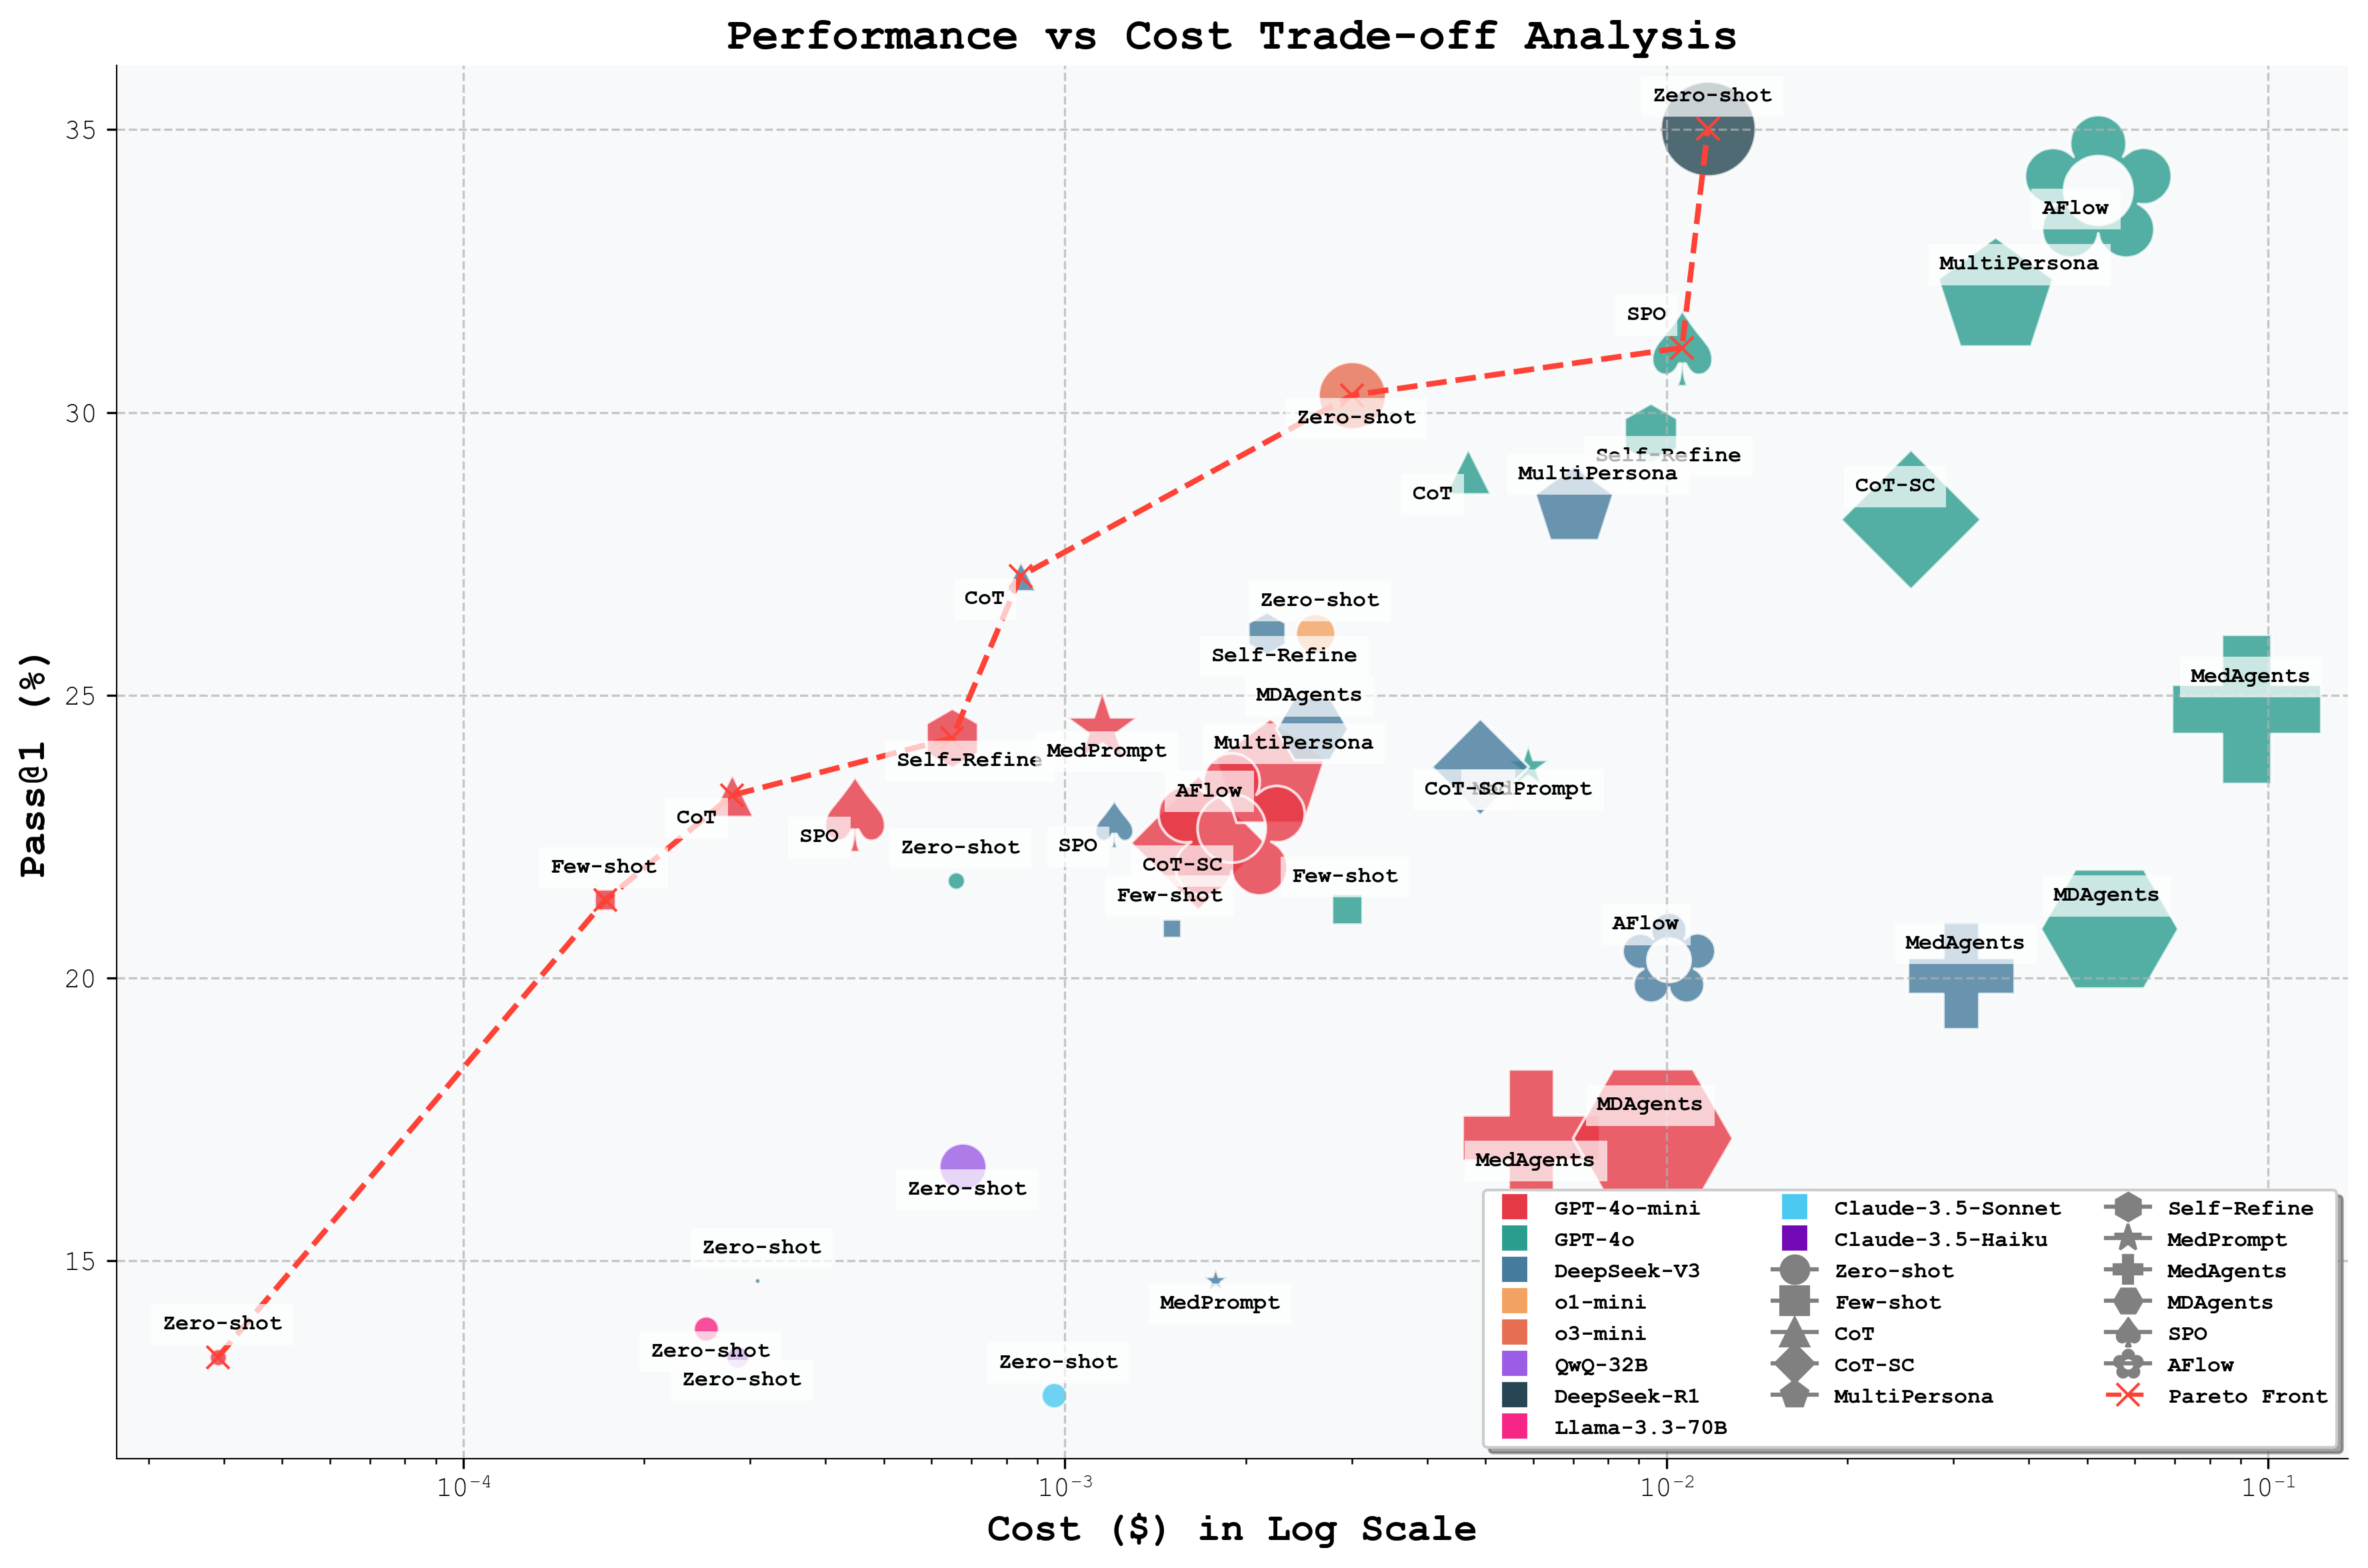

In [13]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns

# Set different font families for different elements
plt.rcParams['font.family'] = 'Courier New'  # Base font
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Custom font settings
title_font = {'family': 'Courier New', 'size': 16, 'weight': 'bold'}
legend_font = {'family': 'Courier New', 'size': 8, 'weight': 'bold'}
number_font = {'family': 'Courier New', 'size': 10}

tasks = {
    'medqa': ['test_hard'],
    'pubmedqa': ['test_hard'],
    'medmcqa': ['test_hard'],
    'medbullets': ['test_hard'],
    'mmlu': ['test_hard'],
    'mmlu-pro': ['test_hard'],
    'afrimedqa': ['test_hard'],
}
models = [
    'gpt-4o-mini',
    'gpt-4o',
    'DeepSeek-V3',
    'o1-mini',
    'o3-mini',
    'QwQ-32B-Preview',
    'DeepSeek-R1',
    'Llama-3.3-70B-Instruct-Turbo',
    'claude-3-5-sonnet',
    'claude-3-5-haiku'
]
methods = ['zero_shot', 'few_shot', 'cot', 'cot_sc-5', 'multipersona-2', 'self_refine-3', 'medprompt-3', 'medagents', 'mdagents', 'spo', 'aflow']

# Aggregate performance, cost, and time data per model-method combination
model_method_stats = {}

for task in tasks:
    for subtask in tasks[task]:
        for model in models:
            for method in methods:
                model_method = f"{model}+{method.split('-')[0]}"  # Create a combined key
                file_path = f'./output/{task}/{model}-{task}-{subtask}-{method}.json'
                try:
                    data = load_json(file_path)
                    dedup_data = deduplicate_data(data)
                    acc = calculate_accuracy(dedup_data)
                    total_samples = len(dedup_data)
                    cost_per_sample = calculate_cost_from_token_usage(dedup_data, model)
                    avg_time = calculate_time_from_data(dedup_data)
                    correct = acc * total_samples

                    if 'DeepSeek-V3' in model_method:
                        avg_time /= 10      # together ai has a slower speed
                    if model_method not in model_method_stats:
                        model_method_stats[model_method] = {
                            'total_correct': 0.0,
                            'total_samples': 0,
                            'total_cost': 0.0,
                            'total_time': 0.0,
                            'base_model': model  # Store the base model for grouping
                        }

                    model_method_stats[model_method]['total_correct'] += correct
                    model_method_stats[model_method]['total_samples'] += total_samples
                    model_method_stats[model_method]['total_cost'] += cost_per_sample * total_samples
                    model_method_stats[model_method]['total_time'] += avg_time * total_samples
                except Exception as e:
                    # print(f"Skipping {file_path}: {e}")
                    pass

# Prepare lists for plotting
model_method_names = []
avg_accuracies = []
avg_costs = []
avg_times = []
base_models = []

for model_method, stats in model_method_stats.items():
    if stats['total_samples'] > 0:
        overall_acc = stats['total_correct'] / stats['total_samples']
        avg_cost = stats['total_cost'] / stats['total_samples']
        overall_time = stats['total_time'] / stats['total_samples']
        
        model_method_names.append(model_method)
        avg_accuracies.append(overall_acc)
        avg_costs.append(avg_cost)
        avg_times.append(overall_time)
        base_models.append(stats['base_model'])
        
        print(f"Model-Method: {model_method} -> Overall Accuracy: {overall_acc*100:.1f}% | "
              f"Avg Cost per Sample: ${avg_cost:.4f} | Avg Time per Sample: {overall_time:.4f}s")

# Compute Pareto frontier
points = list(zip(avg_costs, avg_accuracies))
pareto_indices = []
for i, (cost, acc) in enumerate(points):
    dominated = False
    for j, (other_cost, other_acc) in enumerate(points):
        if i == j:
            continue
        if (other_cost <= cost and other_acc >= acc) and ((other_cost < cost) or (other_acc > acc)):
            dominated = True
            break
    if not dominated:
        pareto_indices.append(i)

# Sort Pareto frontier points
pareto_points = sorted([(avg_costs[i], avg_accuracies[i], model_method_names[i]) 
                       for i in pareto_indices], key=lambda x: x[0])
pareto_costs = [pt[0] for pt in pareto_points]
pareto_accs = [pt[1]*100 for pt in pareto_points]

# Plot with distinction between base models and methods
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

# Define color map for base models and marker map for methods
base_model_colors = {
    'gpt-4o-mini': '#E63946',         # Vibrant red
    'gpt-4o': '#2A9D8F',              # Deep teal
    'DeepSeek-V3': '#457B9D',         # Rich blue
    'o1-mini': '#F4A261',             # Sandy orange
    'o3-mini': '#E76F51',             # Burnt orange
    'QwQ-32B-Preview': '#9B5DE5',     # Royal purple
    'DeepSeek-R1': '#264653',         # Dark slate
    'Llama-3.3-70B-Instruct-Turbo': '#F72585',  # Hot pink
    'claude-3-5-sonnet': '#4CC9F0',   # Electric blue
    'claude-3-5-haiku': '#7209B7'     # Deep purple
}

model_map = {
    'gpt-4o-mini': 'GPT-4o-mini',
    'gpt-4o': 'GPT-4o',
    'o1-mini': 'o1-mini',
    'o3-mini': 'o3-mini',
    'DeepSeek-V3': 'DeepSeek-V3',
    'DeepSeek-R1': 'DeepSeek-R1',
    'QwQ-32B-Preview': 'QwQ-32B',
    'Llama-3.3-70B-Instruct-Turbo': 'Llama-3.3-70B',
    'claude-3-5-sonnet': 'Claude-3.5-Sonnet',
    'claude-3-5-haiku': 'Claude-3.5-Haiku'
}

method_markers = {
    'zero_shot': 'o',
    'few_shot': 's', 
    'cot': '^',
    'cot_sc': 'D',
    'multipersona': 'p',
    'self_refine': 'h',
    'medprompt': '*',
    'medagents': 'P',
    'mdagents': 'H',
    'spo': '$\u2660$',
    'aflow': '$\u273F$'
}

# Method name mapping
method_names = {
    'zero_shot': 'Zero-shot',
    'few_shot': 'Few-shot',
    'cot': 'CoT',
    'cot_sc': 'CoT-SC',
    'multipersona': 'MultiPersona',
    'self_refine': 'Self-Refine',
    'medprompt': 'MedPrompt',
    'medagents': 'MedAgents',
    'mdagents': 'MDAgents',
    'spo': 'SPO',
    'aflow': 'AFlow'
}

size_scale = 50
max_dist_x = 0.01
max_dist_y = 1.5
    
# Keep track of annotated points to avoid overlap
annotated_points = []

for i, model_method in enumerate(model_method_names):
    base_model = base_models[i]
    method = model_method.split('+', 1)[1]
    
    if method not in method_markers:
        continue
        
    cost = avg_costs[i]
    acc_percent = avg_accuracies[i] * 100
    time_val = avg_times[i]
    marker_size = time_val * size_scale

    color = base_model_colors[base_model]
    marker = method_markers[method]

    plt.scatter(cost, acc_percent, s=marker_size, marker=marker, 
               color=color, alpha=0.8, edgecolors='white', linewidth=1)
    
    should_annotate = True
    for x, y in annotated_points:
        if abs(np.log10(cost) - np.log10(x)) < max_dist_x and abs(acc_percent - y) < max_dist_y:
            should_annotate = False
            break
            
    if should_annotate:
        plt.annotate(method_names[method], (cost, acc_percent),
                    textcoords="offset points", xytext=(-20, 10 * (2 * random.randint(0, 1) - 1)),
                    **legend_font,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        annotated_points.append((cost, acc_percent))

# Overlay Pareto frontier
plt.plot(pareto_costs, pareto_accs, color='#FF4136', 
         linestyle='--', marker='x', markersize=8, linewidth=2, label='Pareto Front')

plt.xlabel("Cost ($) in Log Scale", fontweight='bold')
plt.ylabel("Pass@1 (%)", fontweight='bold')
plt.title("Performance vs Cost Trade-off Analysis", **title_font)
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-axis to log scale with custom number font
plt.xscale('log')
ax.tick_params(axis='both', which='major', labelsize=number_font['size'])
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontfamily(number_font['family'])

# Create custom legend
legend_elements = []

# Add base model colors to legend
for model, color in base_model_colors.items():
    legend_elements.append(Line2D([0], [0], marker='s', color='w', 
                                label=f'{model_map[model]}', markerfacecolor=color, 
                                markersize=10, markeredgecolor='white'))

# Add method markers to legend
for method, marker in method_markers.items():
    legend_elements.append(Line2D([0], [0], marker=marker, color='gray', 
                                label=method_names[method], markersize=10))

# Add Pareto front to legend
legend_elements.append(Line2D([0], [0], marker='x', color='#FF4136', 
                            label='Pareto Front', markersize=8, linestyle='--'))

# Create legend with custom styling
legend = plt.legend(handles=legend_elements, loc='lower right', 
                   bbox_to_anchor=(1.00, 0.00), frameon=True,
                   fancybox=True, shadow=True, prop=legend_font,
                   ncol=3)  # Display legend in 3 columns

# Add a light background color to the plot
ax.set_facecolor('#f8f9fa')
fig.patch.set_facecolor('white')

# Add subtle spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [4]:
import glob
import os
import json

def save_json(file_path, data):
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)

# Recursively find all JSON files in the output directory
output_dir = '../../output'
json_files = glob.glob(os.path.join(output_dir, '**', '*.json'), recursive=True)

print("Starting data deduplication...")

for file_path in json_files:
    try:
        data = load_json(file_path)  # Assuming load_json is defined elsewhere
        # Only proceed if the JSON data is a list
        if isinstance(data, list):
            original_length = len(data)
            deduped_data = deduplicate_data(data)  # Assuming deduplicate_data is defined elsewhere
            deduped_length = len(deduped_data)
            if deduped_length < original_length:
                print(f"Deduplicated {original_length - deduped_length} duplicate entries in {file_path}.")
                save_json(file_path, deduped_data)
            else:
                print(f"No duplicates found in {file_path}.")
        else:
            print(f"Skipping {file_path} (data is not a list).")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

print("Data deduplication process completed!")

Starting data deduplication...
No duplicates found in ./output/medbullets/claude-3-5-sonnet-medbullets-test_hard-zero_shot.json.
No duplicates found in ./output/medbullets/DeepSeek-R1-medbullets-test-prob.json.
No duplicates found in ./output/medbullets/gpt-4o-medbullets-test_hard-few_shot.json.
No duplicates found in ./output/medbullets/DeepSeek-V3-medbullets-test_hard-few_shot.json.
No duplicates found in ./output/medbullets/gpt-4o-mini-medbullets-test_hard-zero_shot.json.
No duplicates found in ./output/medbullets/o3-mini-medbullets-test-prob.json.
No duplicates found in ./output/medbullets/DeepSeek-V3-medbullets-test_hard-zero_shot.json.
No duplicates found in ./output/medbullets/o1-mini-medbullets-test-zero_shot.json.
No duplicates found in ./output/medbullets/QwQ-32B-Preview-medbullets-test-prob.json.
No duplicates found in ./output/medbullets/claude-3-5-haiku-medbullets-test-prob.json.
No duplicates found in ./output/medbullets/DeepSeek-V3-medbullets-test-zero_shot.json.
No dupl

Error processing ./output/mmlu/claude-3-5-haiku-mmlu-test-prob.json: Expecting value: line 5862 column 15 (char 245150)

Levenshtein Similarity Statistics:
+-----------------------------------------+-------+--------+---------+-------+--------+-------------------+
|                Model-Task               |  Mean | Median | Std Dev |  Min  |  Max   | Number of Samples |
+-----------------------------------------+-------+--------+---------+-------+--------+-------------------+
|            medqa_gpt-35-turbo           | 25.46 | 25.00  |   4.67  |  8.00 | 67.00  |        1273       |
|               medqa_gpt-4               | 23.40 | 23.00  |   2.54  | 11.00 | 35.00  |        1273       |
|            medqa_gpt-4o-mini            | 24.54 | 24.00  |   3.53  | 15.00 | 41.00  |        1273       |
|               medqa_gpt-4o              | 24.55 | 24.00  |   4.07  | 11.00 | 52.00  |        1273       |
|              medqa_o1-mini              | 21.65 | 22.00  |   2.77  |  5.00 | 37.00  | 

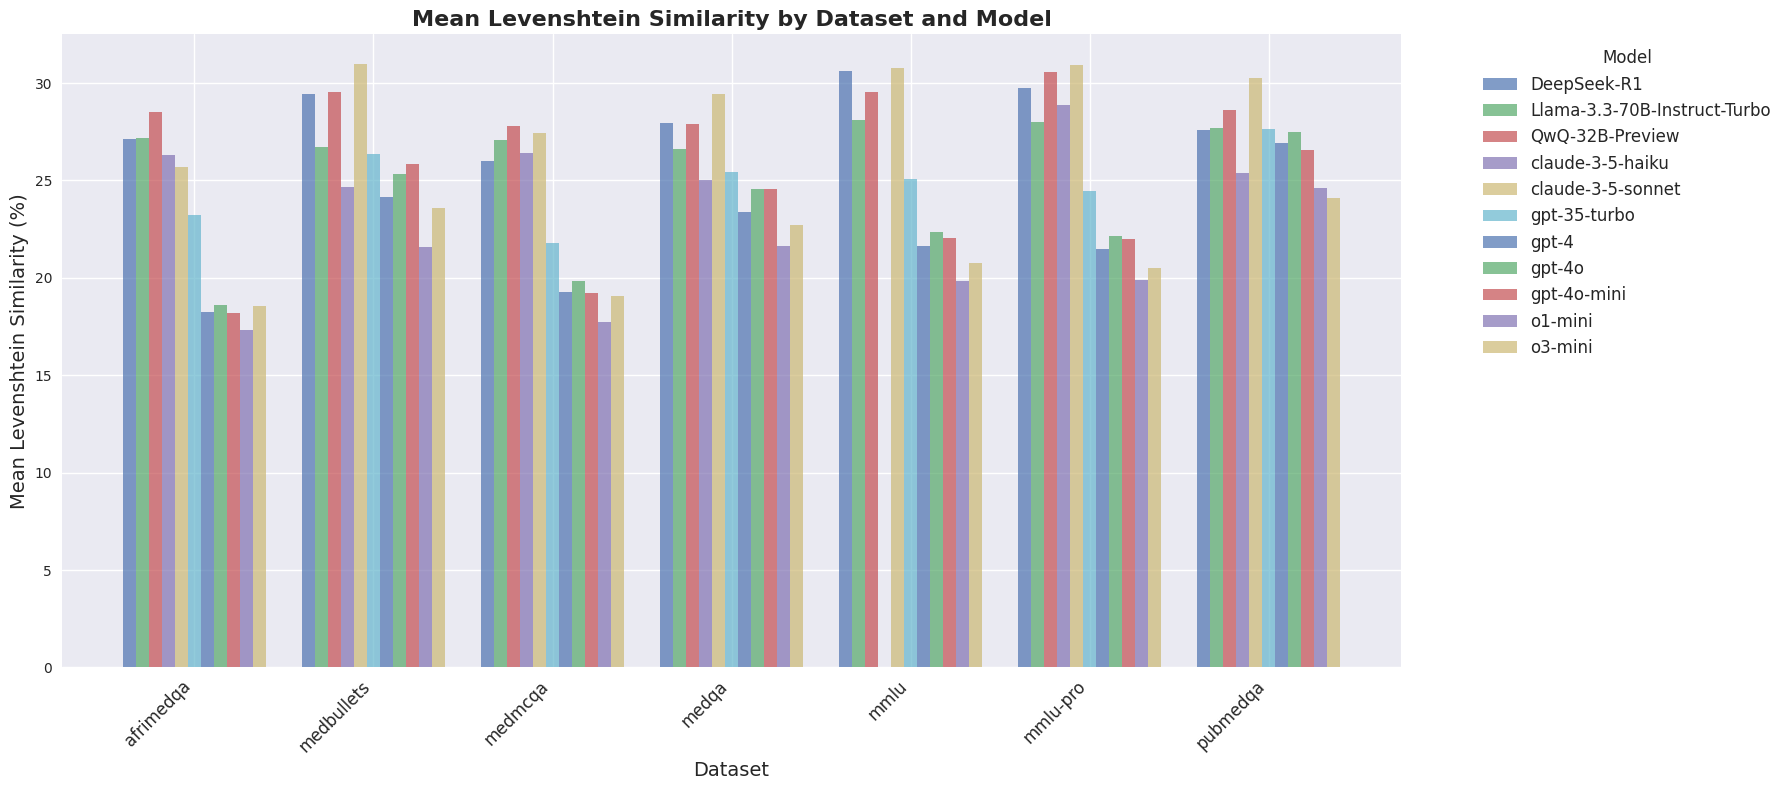

In [23]:
# Calculate Levenshtein distance for each dataset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

lev_distances = defaultdict(list)
tasks = {
    'medqa': ['test'],
    'pubmedqa': ['test'],
    'medmcqa': ['test'],
    'medbullets': ['test'],
    'mmlu': ['test'],
    'mmlu-pro': ['test'],
    'afrimedqa': ['test'],
}
models = [
    'gpt-35-turbo',
    'gpt-4',
    'gpt-4o-mini',
    'gpt-4o',
    'o1-mini',
    'o3-mini',
    'QwQ-32B-Preview',
    'DeepSeek-R1',
    'Llama-3.3-70B-Instruct-Turbo',
    'DeepSeek-V3',
    'claude-3-5-sonnet',
    'claude-3-5-haiku'
]

for task in tasks:
    for subtask in tasks[task]:
        for model in models:
            try:
                file_path = f'./output/{task}/{model}-{task}-{subtask}-prob.json'
                data = load_json(file_path)
                for item in data:
                    if 'q2' in item and 'generated_text' in item:
                        distance = item['levenshtein_distance']
                        ratio = int(round((1 - distance/max(len(item['q2']), len(item['generated_text']))) * 100))
                        lev_distances[f"{task}_{model}"].append(ratio)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# Create a table of summary statistics
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model-Task", "Mean", "Median", "Std Dev", "Min", "Max", "Number of Samples"]

for key, distances in lev_distances.items():
    table.add_row([
        key,
        f"{np.mean(distances):.2f}",
        f"{np.median(distances):.2f}", 
        f"{np.std(distances):.2f}",
        f"{np.min(distances):.2f}",
        f"{np.max(distances):.2f}",
        f"{len(distances)}"
    ])

print("\nLevenshtein Similarity Statistics:")
print(table)

try:
    plt.style.use("seaborn-v0_8")
except OSError as e:
    print(f"Warning: {e}. Falling back to the default style.")
    plt.style.use('default')
fig, ax = plt.subplots(figsize=(18, 8))

# Aggregate mean Levenshtein similarities and group by dataset and model
# Assuming lev_distances keys are in "dataset-model" format
dataset_models = {}
for key, values in lev_distances.items():
    if '-' not in key:
        continue
    dataset, model = key.split('_', 1)
    mean_similarity = np.mean(values)
    if dataset not in dataset_models:
        dataset_models[dataset] = {}
    dataset_models[dataset][model] = mean_similarity

# Sort datasets and get the union of all models present
datasets = sorted(dataset_models.keys())
all_models = sorted({model for models_dict in dataset_models.values() for model in models_dict.keys()})

# Define positions for grouped bar plot
n_datasets = len(datasets)
n_models = len(all_models)
bar_width = 0.8 / n_models
x = np.arange(n_datasets)

# Create a grouped bar plot: iterate over models and plot each bar with an offset,
# using a lighter fill (via alpha) and thicker bar edges (via linewidth)
for i, model in enumerate(all_models):
    offset = (i - (n_models - 1) / 2) * bar_width  # Center bars within each dataset group
    means = [dataset_models[ds].get(model, np.nan) for ds in datasets]
    ax.bar(x + offset, means, width=bar_width, label=model, alpha=0.7, linewidth=2)

# Set descriptive titles and labels with enhanced font sizes
ax.set_title('Mean Levenshtein Similarity by Dataset and Model', fontsize=16, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=14)
ax.set_ylabel('Mean Levenshtein Similarity (%)', fontsize=14)

# Set x-ticks with dataset labels; rotate labels for clarity
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45, ha='right', fontsize=12)

# Place the legend outside the plot area
ax.legend(title="Model", fontsize=12, title_fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Skipping ./output/medqa/gpt-35-turbo-medqa-test-zero_shot.json: [Errno 2] No such file or directory: './output/medqa/gpt-35-turbo-medqa-test-zero_shot.json'
Skipping ./output/medqa/gpt-35-turbo-medqa-test-few_shot.json: [Errno 2] No such file or directory: './output/medqa/gpt-35-turbo-medqa-test-few_shot.json'
Skipping ./output/medqa/gpt-35-turbo-medqa-test-cot.json: [Errno 2] No such file or directory: './output/medqa/gpt-35-turbo-medqa-test-cot.json'
Skipping ./output/medqa/gpt-35-turbo-medqa-test-cot_sc-5.json: [Errno 2] No such file or directory: './output/medqa/gpt-35-turbo-medqa-test-cot_sc-5.json'
Skipping ./output/medqa/gpt-4-medqa-test-zero_shot.json: [Errno 2] No such file or directory: './output/medqa/gpt-4-medqa-test-zero_shot.json'
Skipping ./output/medqa/gpt-4-medqa-test-few_shot.json: [Errno 2] No such file or directory: './output/medqa/gpt-4-medqa-test-few_shot.json'
Skipping ./output/medqa/gpt-4-medqa-test-cot.json: [Errno 2] No such file or directory: './output/medqa/

Skipping ./output/medmcqa/DeepSeek-V3-medmcqa-test-few_shot.json: [Errno 2] No such file or directory: './output/medmcqa/DeepSeek-V3-medmcqa-test-few_shot.json'
Skipping ./output/medmcqa/DeepSeek-V3-medmcqa-test-cot.json: [Errno 2] No such file or directory: './output/medmcqa/DeepSeek-V3-medmcqa-test-cot.json'
Skipping ./output/medmcqa/DeepSeek-V3-medmcqa-test-cot_sc-5.json: [Errno 2] No such file or directory: './output/medmcqa/DeepSeek-V3-medmcqa-test-cot_sc-5.json'
Skipping ./output/medmcqa/claude-3-5-sonnet-medmcqa-test-few_shot.json: [Errno 2] No such file or directory: './output/medmcqa/claude-3-5-sonnet-medmcqa-test-few_shot.json'
Skipping ./output/medmcqa/claude-3-5-sonnet-medmcqa-test-cot.json: [Errno 2] No such file or directory: './output/medmcqa/claude-3-5-sonnet-medmcqa-test-cot.json'
Skipping ./output/medmcqa/claude-3-5-sonnet-medmcqa-test-cot_sc-5.json: [Errno 2] No such file or directory: './output/medmcqa/claude-3-5-sonnet-medmcqa-test-cot_sc-5.json'
Skipping ./output/

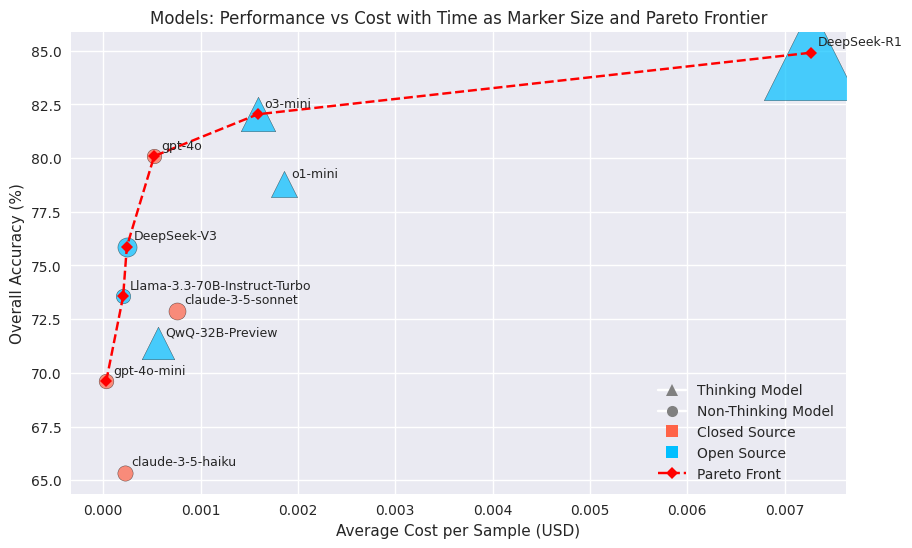

In [25]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Aggregate performance, cost, and time data per model over all experiments
model_stats = {}

for task in tasks:
    for subtask in tasks[task]:
        for model in models:
            for method in methods:
                file_path = f'./output/{task}/{model}-{task}-{subtask}-{method}.json'
                try:
                    data = load_json(file_path)
                    dedup_data = deduplicate_data(data)
                    # calculate_accuracy returns a fraction (0 to 1)
                    acc = calculate_accuracy(dedup_data)
                    total_samples = len(dedup_data)
                    cost_per_sample = calculate_cost_from_token_usage(dedup_data, model)
                    # Get average time per sample from the data
                    avg_time = calculate_time_from_data(dedup_data)
                    # approximate count of correct responses
                    correct = acc * total_samples

                    if model not in model_stats:
                        model_stats[model] = {
                            'total_correct': 0.0,
                            'total_samples': 0,
                            'total_cost': 0.0,
                            'total_time': 0.0
                        }

                    model_stats[model]['total_correct'] += correct
                    model_stats[model]['total_samples'] += total_samples
                    model_stats[model]['total_cost'] += cost_per_sample * total_samples
                    # Multiply avg_time by the number of samples to later compute a weighted average
                    model_stats[model]['total_time'] += avg_time * total_samples
                except Exception as e:
                    print(f"Skipping {file_path}: {e}")

# Prepare lists with aggregated overall accuracy, average cost, and average time per sample for each model.
model_names = []
avg_accuracies = []  # as fraction
avg_costs = []       # in USD per sample
avg_times = []       # in seconds per sample

for model, stats in model_stats.items():
    if stats['total_samples'] > 0:
        overall_acc = stats['total_correct'] / stats['total_samples']  # weighted accuracy
        avg_cost = stats['total_cost'] / stats['total_samples']
        overall_time = stats['total_time'] / stats['total_samples']
        model_names.append(model)
        avg_accuracies.append(overall_acc)
        avg_costs.append(avg_cost)
        avg_times.append(overall_time)
        print(f"Model: {model} -> Overall Accuracy: {overall_acc*100:.1f}% | Avg Cost per Sample: ${avg_cost:.4f} | Avg Time per Sample: {overall_time:.4f}s")
    else:
        print(f"Model: {model} had no processed samples.")

# Compute Pareto frontier among models.
# A model is not Pareto-dominated if no other model has lower (or equal) cost and higher (or equal) accuracy with at least one strict improvement.
points = list(zip(avg_costs, avg_accuracies))
pareto_indices = []
for i, (cost, acc) in enumerate(points):
    dominated = False
    for j, (other_cost, other_acc) in enumerate(points):
        if i == j:
            continue
        if (other_cost <= cost and other_acc >= acc) and ((other_cost < cost) or (other_acc > acc)):
            dominated = True
            break
    if not dominated:
        pareto_indices.append(i)

# Sort Pareto frontier points by cost for a clean overlay.
pareto_points = sorted([(avg_costs[i], avg_accuracies[i], model_names[i]) for i in pareto_indices], key=lambda x: x[0])
pareto_costs = [pt[0] for pt in pareto_points]
pareto_accs = [pt[1]*100 for pt in pareto_points]  # converting to percentage

# Plot all models with customized markers and sizes (using avg_time) to reflect additional dimensions.
plt.figure(figsize=(10, 6))

# Define a scale factor for marker size (adjusted to make the markers smaller)
size_scale = 100

for i, model in enumerate(model_names):
    cost = avg_costs[i]
    acc_percent = avg_accuracies[i] * 100
    time_val = avg_times[i]
    marker_size = time_val * size_scale

    # Determine if the model is a "thinking" model based on keywords.
    lower_model = model.lower()
    is_thinking = any(kw in lower_model for kw in ['r1', 'qwq', 'o1-mini', 'o3-mini'])
    # Determine open source vs closed source: consider models with 'gpt' or 'claude' as closed source.
    is_closed = ('gpt' in lower_model or 'claude' in lower_model)

    # Set marker shape: thinking models get a triangle, non-thinking get a circle.
    marker = '^' if is_thinking else 'o'
    # Set color based on open vs closed source.
    color = 'tomato' if is_closed else 'deepskyblue'

    plt.scatter(cost, acc_percent, s=marker_size, marker=marker, color=color, alpha=0.7, edgecolors='k')
    plt.annotate(model, (cost, acc_percent), textcoords="offset points", xytext=(5, 5), fontsize=9)

# Overlay the Pareto frontier.
plt.plot(pareto_costs, pareto_accs, color='red', linestyle='--', marker='D', markersize=6, label='Pareto Front')

plt.xlabel("Average Cost per Sample (USD)")
plt.ylabel("Overall Accuracy (%)")
plt.title("Models: Performance vs Cost with Time as Marker Size and Pareto Frontier")
plt.grid(True)

# Create a custom legend to explain marker shape and color.
legend_elements = [
    Line2D([0], [0], marker='^', color='w', label='Thinking Model', markerfacecolor='gray', markersize=8, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='Non-Thinking Model', markerfacecolor='gray', markersize=8, markeredgecolor='k'),
    Line2D([0], [0], marker='s', color='tomato', label='Closed Source', markersize=8, linestyle='None'),
    Line2D([0], [0], marker='s', color='deepskyblue', label='Open Source', markersize=8, linestyle='None'),
    Line2D([0], [0], marker='D', color='red', label='Pareto Front', markersize=6, linestyle='--')
]
plt.legend(handles=legend_elements, loc='best')

plt.show()


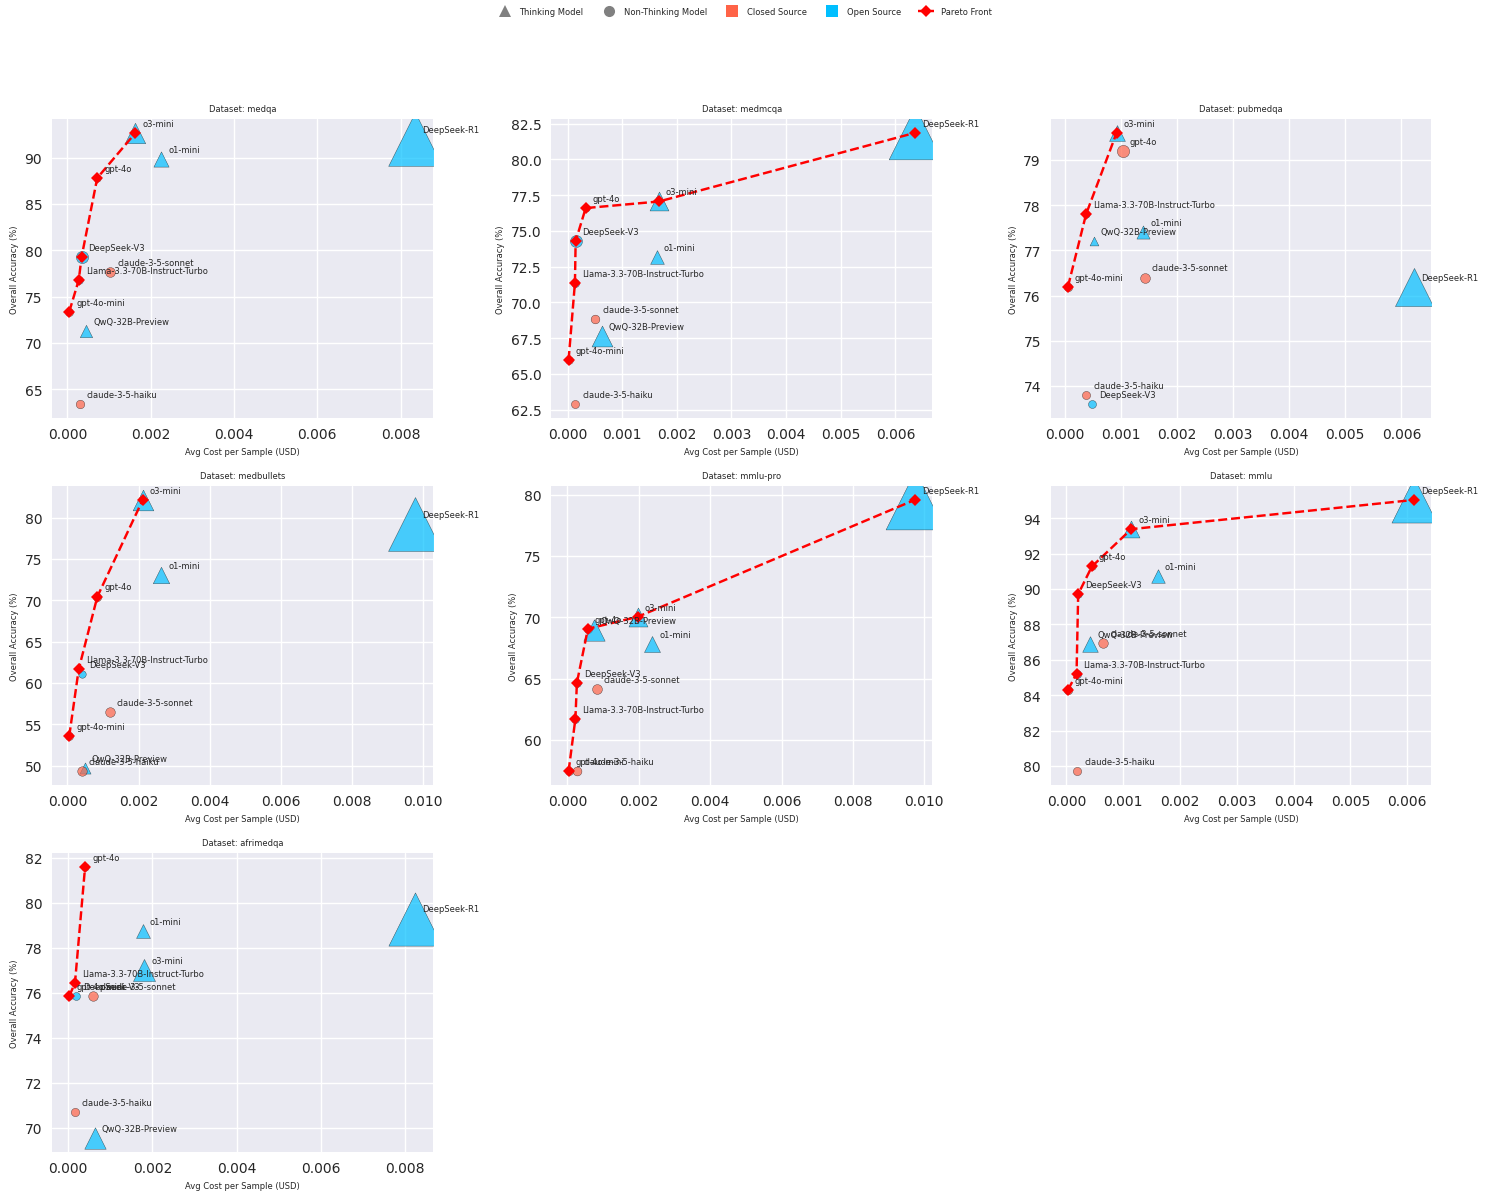

In [26]:
import os
import json
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

datasets = ['medqa', 'medmcqa', 'pubmedqa', 'medbullets', 'mmlu-pro', 'mmlu', 'afrimedqa']
# Create subplots to show dataset-specific performance vs. cost in one figure.
ncols = 3
nrows = math.ceil(len(datasets) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    dataset_stats = {}  # To store aggregated stats per model for this dataset

    for model in model_names:
        model_filename = model.replace('/', '_')
        file_path = os.path.join('.', 'output', dataset, f"{model_filename}-{dataset}-test-zero_shot.json")
        
        if not os.path.exists(file_path):
            print(f"JSON file not found for model '{model}' in dataset '{dataset}': {file_path}")
            continue
        
        with open(file_path, 'r') as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from {file_path}: {e}")
                continue
        
        # Optionally deduplicate data if applicable.
        dedup_data = deduplicate_data(data)
        total_samples = len(dedup_data)
        if total_samples == 0:
            continue
        
        # Compute performance metrics.
        acc = calculate_accuracy(dedup_data)  # returns a fraction between 0 and 1
        cost_per_sample = calculate_cost_from_token_usage(dedup_data, model)
        avg_time = calculate_time_from_data(dedup_data)
        correct = acc * total_samples
        
        dataset_stats[model] = {
            'total_correct': correct,
            'total_samples': total_samples,
            'total_cost': cost_per_sample * total_samples,
            'total_time': avg_time * total_samples
        }
    
    # Prepare lists for plotting for this dataset.
    ds_model_names = []
    ds_avg_accuracies = []   # as fraction
    ds_avg_costs = []        # in USD per sample
    ds_avg_times = []        # in seconds per sample
    
    for model, stats in dataset_stats.items():
        if stats['total_samples'] > 0:
            overall_acc = stats['total_correct'] / stats['total_samples']
            avg_cost = stats['total_cost'] / stats['total_samples']
            overall_time = stats['total_time'] / stats['total_samples']
            ds_model_names.append(model)
            ds_avg_accuracies.append(overall_acc)
            ds_avg_costs.append(avg_cost)
            ds_avg_times.append(overall_time)
    
    # Compute the Pareto frontier for the dataset.
    ds_points = list(zip(ds_avg_costs, ds_avg_accuracies))
    ds_pareto_indices = []
    for i, (cost, acc) in enumerate(ds_points):
        dominated = False
        for j, (other_cost, other_acc) in enumerate(ds_points):
            if i == j:
                continue
            if (other_cost <= cost and other_acc >= acc) and ((other_cost < cost) or (other_acc > acc)):
                dominated = True
                break
        if not dominated:
            ds_pareto_indices.append(i)
    
    ds_pareto_points = sorted(
        [(ds_avg_costs[i], ds_avg_accuracies[i], ds_model_names[i]) for i in ds_pareto_indices],
        key=lambda x: x[0]
    )
    ds_pareto_costs = [pt[0] for pt in ds_pareto_points]
    ds_pareto_accs = [pt[1] * 100 for pt in ds_pareto_points]  # Convert accuracy to percentage
    
    # Plot dataset-specific model points.
    size_scale = 30  # Adjust marker size scale if needed
    for i, model in enumerate(ds_model_names):
        cost = ds_avg_costs[i]
        acc_percent = ds_avg_accuracies[i] * 100
        time_val = ds_avg_times[i]
        marker_size = time_val * size_scale
        
        lower_model = model.lower()
        # Determine marker shape: thinking models get a triangle.
        is_thinking = any(kw in lower_model for kw in ['r1', 'qwq', 'o1-mini', 'o3-mini'])
        marker = '^' if is_thinking else 'o'
        # Determine color based on open vs closed source.
        is_closed = ('gpt' in lower_model or 'claude' in lower_model)
        color = 'tomato' if is_closed else 'deepskyblue'
        
        ax.scatter(cost, acc_percent, s=marker_size, marker=marker, color=color, alpha=0.7, edgecolors='k')
        ax.annotate(model, (cost, acc_percent), textcoords="offset points", xytext=(5, 5), fontsize=6)
    
    # Overlay the Pareto frontier.
    ax.plot(ds_pareto_costs, ds_pareto_accs, color='red', linestyle='--', marker='D', markersize=6)
    ax.set_title(f"Dataset: {dataset}", fontsize=6)
    ax.set_xlabel("Avg Cost per Sample (USD)", fontsize=6)
    ax.set_ylabel("Overall Accuracy (%)", fontsize=6)
    ax.grid(True)

# Disable any extra subplots if the grid is larger than the number of datasets.
for j in range(len(datasets), len(axes)):
    axes[j].axis('off')

# Create one unified legend for all subplots.
legend_elements = [
    Line2D([0], [0], marker='^', color='w', label='Thinking Model', markerfacecolor='gray', markersize=8, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='Non-Thinking Model', markerfacecolor='gray', markersize=8, markeredgecolor='k'),
    Line2D([0], [0], marker='s', color='tomato', label='Closed Source', markersize=8, linestyle='None'),
    Line2D([0], [0], marker='s', color='deepskyblue', label='Open Source', markersize=8, linestyle='None'),
    Line2D([0], [0], marker='D', color='red', label='Pareto Front', markersize=6, linestyle='--')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=5, fontsize=6)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In [19]:
# Create test_hard.json with questions that have low accuracy across models
hard_questions = {}

models = [
    'gpt-4o-mini',
    'gpt-4o', 
    'o1-mini',
    'o3-mini',
    'QwQ-32B-Preview',
    'DeepSeek-R1',
    'Llama-3.3-70B-Instruct-Turbo',
    'DeepSeek-V3',
    'claude-3-5-sonnet',
    'claude-3-5-haiku'
]
methods = ['zero_shot']

hard_bands = {}
for task in tasks:
    # Track correct answers per question across all models
    question_correct_counts = {}
    question_total_counts = {}
    
    # First pass - count correct answers for each question
    for model in models:
        for method in methods:
            try:
                file_path = f'./output/{task}/{model}-{task}-test-{method}.json'
                data = load_json(file_path)
                dedup_data = deduplicate_data(data)

                for item in dedup_data:
                    question = item['realidx']
                    if question not in question_correct_counts:
                        question_correct_counts[question] = 0
                        question_total_counts[question] = 0

                    # Increment total count
                    question_total_counts[question] += 1
                    
                    # Check if answer was correct
                    if item['answer_idx'] == item['predicted_answer']:
                        question_correct_counts[question] += 1
                        
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    hard_questions_task = []
    file_path = f'../../data/{task}/test.jsonl'
    data = load_jsonl(file_path)
    for problem in data:
        total_count = question_total_counts[problem['realidx']]
        correct_count = question_correct_counts[problem['realidx']]
        if correct_count / total_count < 0.5:  # Less than 5/10 correct
            hard_questions_task.append(problem)
    
    hard_correct_ratios = []
    for q in hard_questions_task:
        ratio = question_correct_counts[q['realidx']] / question_total_counts[q['realidx']]
        hard_correct_ratios.append(ratio)
    
    # Count hard questions in each correctness band
    hard_bands[task] = {
        "0/10": len([r for r in hard_correct_ratios if r < 0.1]),
        "1/10": len([r for r in hard_correct_ratios if 0.1 <= r < 0.2]), 
        "2/10": len([r for r in hard_correct_ratios if 0.2 <= r < 0.3]),
        "3/10": len([r for r in hard_correct_ratios if 0.3 <= r < 0.4]),
        "4/10": len([r for r in hard_correct_ratios if 0.4 <= r < 0.5]),
        "5/10": len([r for r in hard_correct_ratios if 0.5 <= r < 0.6]),
        "6/10": len([r for r in hard_correct_ratios if 0.6 <= r < 0.7]),
        "7/10": len([r for r in hard_correct_ratios if 0.7 <= r < 0.8]),
        "8/10": len([r for r in hard_correct_ratios if 0.8 <= r < 0.9]),
        "9/10": len([r for r in hard_correct_ratios if 0.9 <= r < 1.0]),
        "10/10": len([r for r in hard_correct_ratios if r >= 1.0])
    }

    if hard_questions_task:
        if task not in hard_questions:
            hard_questions[task] = {}
        hard_questions[task] = hard_questions_task

    # save_as_jsonl(hard_questions[task], f'../../data/{task}/test_hard.jsonl')

# Print summary table
summary_table = PrettyTable()
summary_table.field_names = ["Task", "Number of Hard Questions"]

for task in hard_questions:
    num_hard = len(hard_questions[task])
    summary_table.add_row([task, num_hard])

print("\nSummary of Hard Questions (correct < 50% across models):")
print(summary_table)



Summary of Hard Questions (correct < 50% across models):
+------------+--------------------------+
|    Task    | Number of Hard Questions |
+------------+--------------------------+
|   medqa    |           100            |
|  pubmedqa  |           100            |
|  medmcqa   |           100            |
| medbullets |            89            |
|    mmlu    |            73            |
|  mmlu-pro  |           100            |
| afrimedqa  |            32            |
+------------+--------------------------+


Processing dataset 'medqa' with 10 model file(s).
Processing dataset 'medmcqa' with 10 model file(s).
Processing dataset 'pubmedqa' with 10 model file(s).
Processing dataset 'medbullets' with 10 model file(s).
Processing dataset 'mmlu-pro' with 10 model file(s).
Processing dataset 'mmlu' with 10 model file(s).
Processing dataset 'afrimedqa' with 10 model file(s).


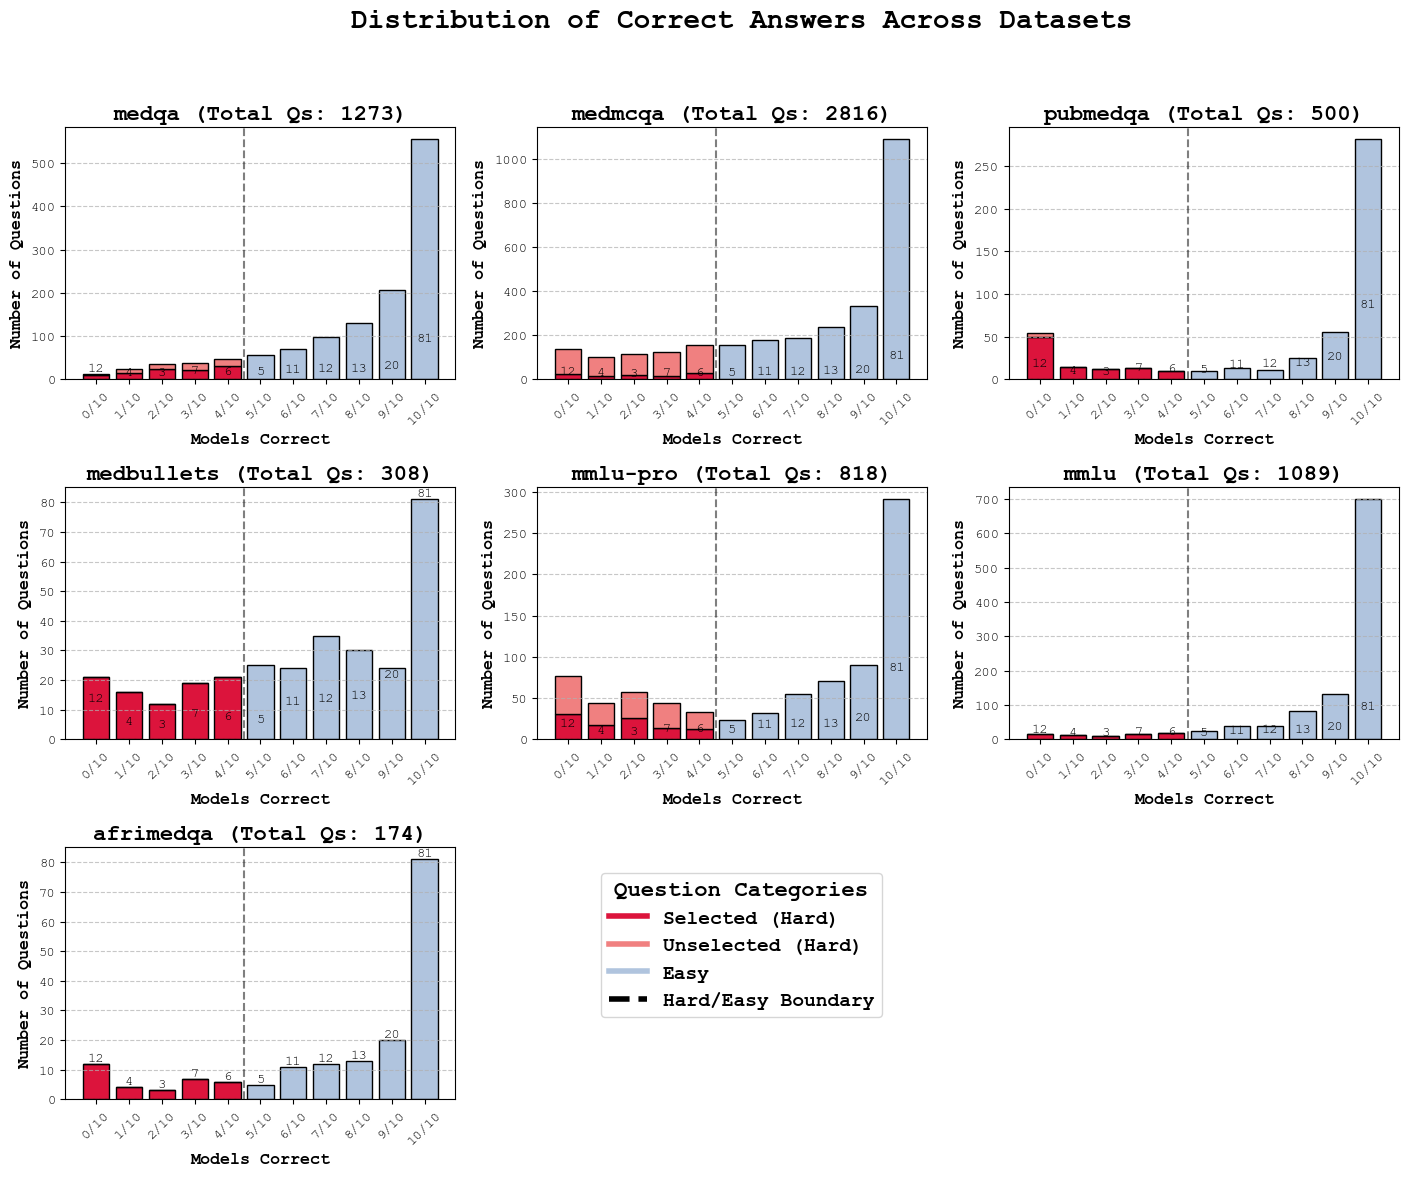

In [48]:
import os
import json
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
from collections import Counter

# Set different font families for different elements
plt.rcParams['font.family'] = 'Courier New'  # Base font
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Custom font settings
title_font = {'family': 'Courier New', 'fontsize': 16, 'fontweight': 'bold'}
legend_font = {'family': 'Courier New', 'fontsize': 8, 'fontweight': 'bold'}
number_font = {'family': 'Courier New', 'fontsize': 10}
axis_font = {'family': 'Courier New', 'fontsize': 12, 'fontweight': 'bold'}

# Assume that both 'datasets' and 'model_names' are defined previously.
datasets = ['medqa', 'medmcqa', 'pubmedqa', 'medbullets', 'mmlu-pro', 'mmlu', 'afrimedqa']
# model_names is assumed to be defined earlier (e.g., model_names = ['claude-3-5-haiku', 'claude-3-5-sonnet', ...])

# Determine subplot grid dimensions (using 3 columns for a balanced layout)
n_datasets = len(datasets)
ncols = 3
nrows = math.ceil(n_datasets / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

# Create empty lists to store legend handles and labels
legend_handles = []
legend_labels = []

for ax, dataset in zip(axes, datasets):
    print(f"Processing dataset '{dataset}' with {len(models)} model file(s).")
    
    # Aggregate the count of models that answered each question correctly.
    # Use the question's unique identifier ("realidx") if available; otherwise, fallback to "question" text.
    question_correct = {}  # key: question identifier; value: count of correct responses across models
    
    for model in models:
        # Convert model name to a file-friendly format.
        model_filename = model.replace('/', '_')
        # Construct the expected JSON filename.
        file_path = os.path.join('.', 'output', dataset, f"{model_filename}-{dataset}-test-zero_shot.json")
        
        if not os.path.exists(file_path):
            print(f"JSON file not found for model '{model}' in dataset '{dataset}' with expected filename: {file_path}")
            continue
        
        with open(file_path, 'r') as f:
            try:
                predictions = json.load(f)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from {file_path}: {e}")
                continue
        
        for entry in predictions:
            # Use "realidx" as unique identifier if provided; otherwise, fallback to the "question" text.
            qid = entry.get("realidx") or entry.get("question", "unknown_question")
            # Determine whether the model's answer is correct.
            predicted = str(entry.get("predicted_answer", "")).strip()
            correct_ans = str(entry.get("answer_idx", "")).strip()
            # Initialize count for this question if not already present.
            if qid not in question_correct:
                question_correct[qid] = 0
            if predicted == correct_ans:
                question_correct[qid] += 1

    # Assume the total number of models equals the length of model_names.
    total_models = len(models)
    
    # Compute the distribution: count how many questions received k correct answers (k = 0, 1, ..., total_models).
    distribution = Counter(question_correct.values())
    
    # Prepare data for plotting: ensure counts for all possible correct responses are present.
    x_values = list(range(total_models + 1))
    y_counts = [distribution.get(k, 0) for k in x_values]
    y_counts_selected = [hard_bands[dataset][f"{k}/{total_models}"] for k in x_values]
    y_counts_unselected = [y_counts[i] - y_counts_selected[i] for i in range(len(x_values))]
    x_labels = [f"{k}/{total_models}" for k in x_values]

    # Create a stacked bar plot in the corresponding subplot axis, stacking the 'selected' and 'unselected' counts.
    colors_selected = ['crimson' if k/total_models < 0.5 else 'skyblue' for k in x_values]
    # Use a lighter shade for the unselected portion.
    colors_unselected = ['lightcoral' if k/total_models < 0.5 else 'lightsteelblue' for k in x_values]
    selected_bars = ax.bar(x_values, y_counts_selected, color=colors_selected, edgecolor='black', label='Selected')
    unselected_bars = ax.bar(x_values, y_counts_unselected, bottom=y_counts_selected, color=colors_unselected, edgecolor='black', label='Unselected')
    
    # Add vertical dashed line at x = total_models/2 to separate hard and easy regions
    ax.axvline(x=(total_models - 1)/2, color='black', linestyle='--', alpha=0.5)
    
    ax.set_xlabel("Models Correct", fontdict=axis_font)
    ax.set_ylabel("Number of Questions", fontdict=axis_font)
    ax.set_title(f"{dataset} (Total Qs: {sum(y_counts)})", fontdict=title_font)
    ax.set_xticks(x_values)
    ax.set_xticklabels(x_labels, rotation=45, fontdict=number_font)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Annotate each bar with its count value for added clarity.
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', 
                   ha='center', va='bottom', fontdict=number_font)

# Hide any unused subplots.
for ax in axes[n_datasets:]:
    ax.axis('off')

# Add a single legend for all subplots
legend_elements = [
    Line2D([0], [0], color='crimson', lw=4, label='Selected (Hard)'),
    Line2D([0], [0], color='lightcoral', lw=4, label='Unselected (Hard)'),
    Line2D([0], [0], color='lightsteelblue', lw=4, label='Easy'),
    Line2D([0], [0], color='black', linestyle='--', lw=4, label='Hard/Easy Boundary')
]
fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(0.6, 0.2), 
          title='Question Categories', title_fontproperties={'weight': 'bold', 'size': 16}, prop={'size': 14, 'weight': 'bold'})

fig.suptitle("Distribution of Correct Answers Across Datasets", weight='bold', fontsize=20)
fig.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust layout to make room for legend
plt.show()
